In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We now have two ways in which to proceed:
1. Run the convolutional base above over our dataset, record its output to a Numpy array on disk and then use this output as input to a standalone, densely connected classifier
2. Extending the convolutional base with dense layer on top and run the whole thing end to end with our input data. This allows the use of image augmentation

We will consider both in turn

#### 1. Feature extraction without data augmentation

In [8]:
# We extract features from these images by calling the predict method of the conv_base model
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = '../datasets/cats_and_dogs_small/train/'
validation_dir = '../datasets/cats_and_dogs_small/validation'
test_dir = '../datasets/cats_and_dogs_small/test'

In [7]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20

In [8]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [9]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# These extracted features have the shape (samples, 4, 4, 512) and we need to flatten them
# to feed them to a densely connected classifier
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [11]:
# Now we can use a densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                   epochs = 20,
                   batch_size = 20,
                   validation_data = (validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/20
2000/2000 [==============================] - 2s 781us/step - loss: 0.6396 - acc: 0.6355 - val_loss: 0.4756 - val_acc: 0.8210
Epoch 2/20
2000/2000 [==============================] - 1s 370us/step - loss: 0.4475 - acc: 0.7915 - val_loss: 0.3831 - val_acc: 0.8450
Epoch 3/20
2000/2000 [==============================] - 1s 367us/step - loss: 0.3738 - acc: 0.8420 - val_loss: 0.3382 - val_acc: 0.8730
Epoch 4/20
2000/2000 [==============================] - 1s 363us/step - loss: 0.3347 - acc: 0.8545 - val_loss: 0.3182 - val_acc: 0.8660
Epoch 5/20
2000/2000 [==============================] - 1s 365us/step - loss: 0.3021 - acc: 0.8735 - val_loss: 0.2916 - val_acc: 0.8840
Epoch 6/20
2000/2000 [==============================] - 1s 365us/step - loss: 0.2800 - acc: 0.8855 - val_loss: 0.2859 - val_acc: 0.8900
Epoch 7/20
2000/2000 [==============================] - 1s 361us/step - loss: 0.2601 - acc: 0.9035 - val_loss: 0.2751 - val_acc: 0.8900


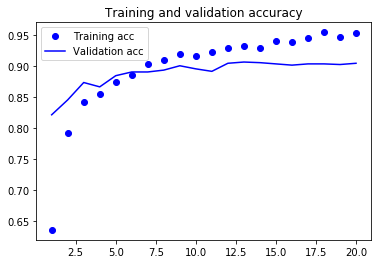

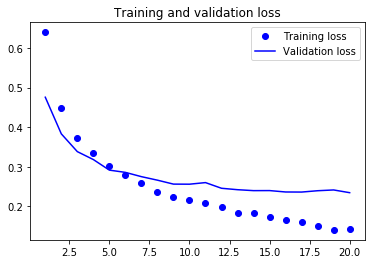

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
# The model trains very fast and the validation accuracy is pretty good (90%) but we can see
# some signs of overfitting. We can now try the second technique (running the dataset through the whole
# conv_base and using image augmentation).
# BTW: note that the next method is very GPU intensive so the first method is to be preferred if
# there is no access to a GPU machine

#### 2. Feature extraction with data augmentation

In [12]:
# Pre-trained models behave like layers, so it is quite easy to add a conv_base to a Sequential model
from keras import models
from keras import layers

# We freeze the weights of the conv_base to contain the size of the model
conv_base.trainable=False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

# We can see that the number of trainable parameters is limited to those in the Dense layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
# Now we can start training the model with the same data augmentation we used before.
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
# No image augmentation for the validation data!

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


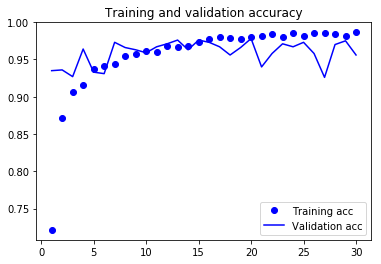

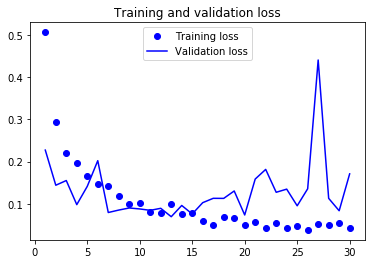

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# We can now see no overfitting and a validation accuracy of 96% which is much better
# than when we trained the convnet from scratch.

#### Fine tuning

In [3]:
# Fine tuning refers to the "unfreezing" of the last few convolutional layers
# So that their weights can be updated on the basis of our data. Generally
# only the last "block" of layers is fine tuned. The steps are as follows:
#
# 1 Add your custom network on top of an already-trained base network.
# 2 Freeze the base network.
# 3 Train the part you added.
# 4 Unfreeze some layers in the base network.
# 5 Jointly train both these layers and the part you added.
#
# We've already done 1-3 above. Let's now do 4 and 5.
# Specifically, we will "unfreeze" block5_conv1, block5_conv2, and block5_conv3 (see summary() for details)

In [4]:
# This is how the last 3 layers will be set to trainable.
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-5),
                      metrics=['acc'])

history = model.fit_generator(
              train_generator,
              steps_per_epoch=100,
              epochs=100,
              validation_data=validation_generator,
              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 37s 368ms/step - loss: 0.5510 - acc: 0.7210 - val_loss: 0.3469 - val_acc: 0.8480
Epoch 2/100
100/100 [==============================] - 35s 345ms/step - loss: 0.4034 - acc: 0.8190 - val_loss: 0.3059 - val_acc: 0.8630
Epoch 3/100
100/100 [==============================] - 35s 348ms/step - loss: 0.3351 - acc: 0.8430 - val_loss: 0.2242 - val_acc: 0.8990
Epoch 4/100
100/100 [==============================] - 35s 350ms/step - loss: 0.3070 - acc: 0.8670 - val_loss: 0.2010 - val_acc: 0.9130
Epoch 5/100
100/100 [==============================] - 35s 351ms/step - loss: 0.2851 - acc: 0.8795 - val_loss: 0.1989 - val_acc: 0.9060
Epoch 6/100
100/100 [==============================] - 35s 351ms/step - loss: 0.2734 - acc: 0.8790 - val_loss: 0.1969 - val_acc: 0.9090
Epoch 7/100
100/100 [==============================] - 35s 355ms/step - loss: 0.2624 - acc: 0.8915 - val_loss: 0.1869 - val_acc: 0.9170
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 35s 353ms/step - loss: 0.0450 - acc: 0.9865 - val_loss: 0.1937 - val_acc: 0.9320
Epoch 62/100
100/100 [==============================] - 35s 353ms/step - loss: 0.0503 - acc: 0.9785 - val_loss: 0.2018 - val_acc: 0.9360
Epoch 63/100
100/100 [==============================] - 35s 353ms/step - loss: 0.0515 - acc: 0.9800 - val_loss: 0.2205 - val_acc: 0.9350
Epoch 64/100
100/100 [==============================] - 35s 354ms/step - loss: 0.0389 - acc: 0.9860 - val_loss: 0.2166 - val_acc: 0.9370
Epoch 65/100
100/100 [==============================] - 35s 353ms/step - loss: 0.0569 - acc: 0.9800 - val_loss: 0.2575 - val_acc: 0.9300
Epoch 66/100
100/100 [==============================] - 35s 353ms/step - loss: 0.0489 - acc: 0.9835 - val_loss: 0.2152 - val_acc: 0.9350
Epoch 67/100
100/100 [==============================] - 35s 352ms/step - loss: 0.0332 - acc: 0.9870 - val_loss: 0.5110 - val_acc: 0.8970
Epoch 68/100
100/100 [===================

In [16]:
# We can finally evaluate the model on the test data
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
# We can see that we get a bit of extra performance from the final fine-tuning.

Found 1000 images belonging to 2 classes.
test acc: 0.941999993324
